# Guia 03: Optimizacion y Regularizacion en Deep Learning

## Electiva II - Deep Learning | Tecnologico de Antioquia

---

**Objetivo de aprendizaje:** Comprender y aplicar tecnicas de optimizacion y regularizacion para mejorar el rendimiento y evitar el sobreajuste en redes neuronales.

**Conceptos nuevos:**
- Optimizadores: SGD, Adam, RMSprop, Adagrad
- Overfitting vs Underfitting
- Dropout
- Batch Normalization
- Early Stopping
- Regularizacion L1 y L2
- Learning Rate Scheduling

**Prerrequisito:** Guia 02 - Redes Neuronales con Keras

**Duracion estimada:** 3 horas

> **IMPORTANTE:** Las secciones marcadas con ✍️ requieren tu respuesta escrita. Estas respuestas son parte de tu evaluacion.

---
## 1. Configuracion del Entorno

In [4]:
# ============================================================
# Importacion de librerias necesarias
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Configuracion de estilo para graficas
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# ============================================================
# Semilla para reproducibilidad
# ============================================================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ============================================================
# Verificar version de TensorFlow y GPU disponible
# ============================================================
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")
print("\nEntorno configurado correctamente.")

TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Entorno configurado correctamente.


---
## 2. Marco Teorico

### 2.1 El problema del entrenamiento: ¿por que no basta con construir la red?

En la Guia 02 aprendimos a construir redes neuronales multicapa con Keras. Pudimos resolver MNIST con buena precision. Sin embargo, **construir la arquitectura es solo la mitad del trabajo**. La otra mitad, igualmente critica, es **como entrenamos** esa red.

Imagina que diseñas un auto de carreras perfecto: motor potente, aerodinamica ideal, llantas de alta gama. Pero si no sabes conducirlo bien, no ganaras la carrera. De manera similar, una red neuronal bien diseñada puede fallar miserablemente si:

1. **El optimizador es inadecuado** (como usar la marcha equivocada en el auto)
2. **El modelo memoriza los datos de entrenamiento** en lugar de aprender patrones generales (overfitting)
3. **El modelo es demasiado simple** para capturar la complejidad del problema (underfitting)
4. **No sabemos cuando parar** el entrenamiento

En esta guia abordaremos sistematicamente cada uno de estos problemas.

---

### 2.2 Overfitting vs Underfitting

Estos son los dos problemas fundamentales del aprendizaje automatico:

#### Underfitting (Subajuste)
El modelo es **demasiado simple** para capturar los patrones de los datos. Es como un estudiante que no estudia lo suficiente: no aprende ni lo basico.

**Sintomas:**
- Accuracy bajo en entrenamiento Y en validacion
- El modelo no mejora aunque entrene mas epocas
- Las curvas de loss de train y validacion son altas y cercanas entre si

**Causas comunes:**
- Modelo con muy pocas neuronas/capas
- Pocas epocas de entrenamiento
- Learning rate demasiado bajo
- Features insuficientes

#### Overfitting (Sobreajuste)
El modelo **memoriza** los datos de entrenamiento en lugar de aprender patrones generalizables. Es como un estudiante que se aprende las respuestas del examen de memoria pero no entiende los conceptos: le ira bien en ese examen especifico, pero fallara en cualquier pregunta nueva.

**Sintomas:**
- Accuracy MUY alto en entrenamiento pero bajo en validacion
- La curva de loss de entrenamiento baja pero la de validacion sube
- Gran brecha entre rendimiento en train vs test

**Causas comunes:**
- Modelo demasiado complejo para la cantidad de datos
- Pocos datos de entrenamiento
- Entrenar demasiadas epocas
- No usar regularizacion

#### El punto ideal
Lo que buscamos es el **equilibrio** entre underfitting y overfitting: un modelo lo suficientemente complejo para capturar patrones reales, pero no tanto que memorice ruido.

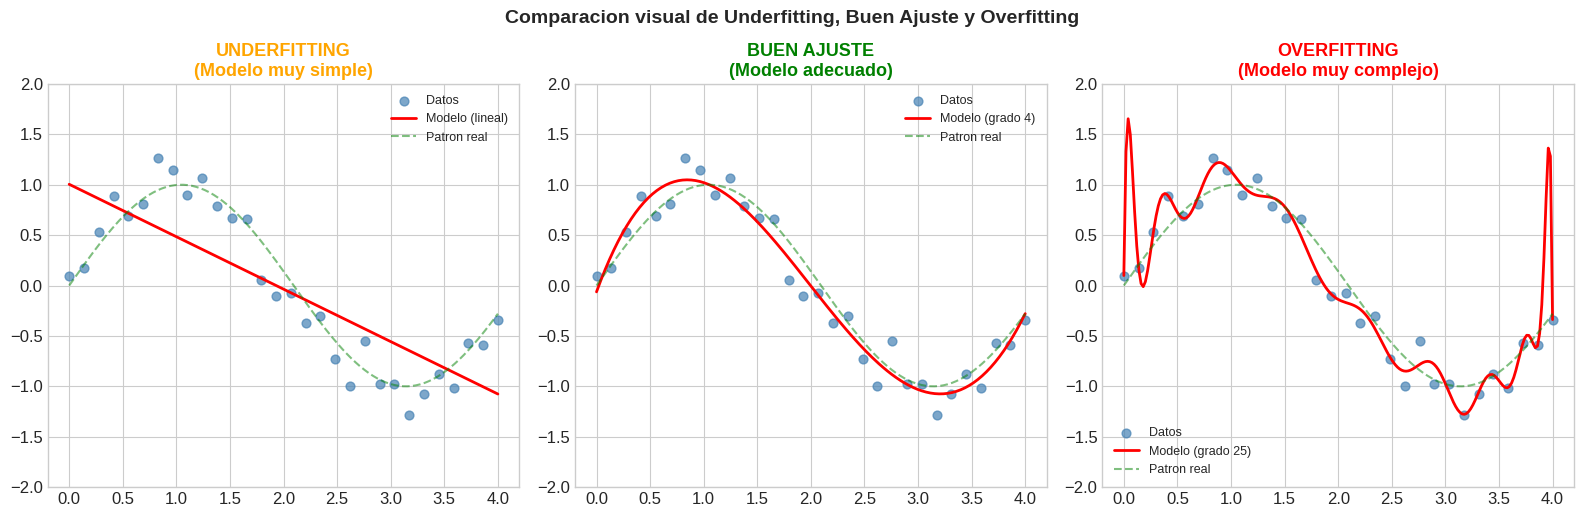

In [5]:
# ============================================================
# Grafica conceptual: Underfitting vs Overfitting vs Ideal
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Datos de ejemplo con ruido
np.random.seed(42)
x = np.linspace(0, 4, 30)
y_real = np.sin(x * 1.5)
y_ruido = y_real + np.random.normal(0, 0.2, len(x))
x_fino = np.linspace(0, 4, 200)

# Underfitting: modelo lineal
coefs_1 = np.polyfit(x, y_ruido, 1)
y_under = np.polyval(coefs_1, x_fino)
axes[0].scatter(x, y_ruido, c='steelblue', s=40, alpha=0.7, label='Datos')
axes[0].plot(x_fino, y_under, 'r-', linewidth=2, label='Modelo (lineal)')
axes[0].plot(x_fino, np.sin(x_fino * 1.5), 'g--', linewidth=1.5, alpha=0.5, label='Patron real')
axes[0].set_title('UNDERFITTING\n(Modelo muy simple)', fontsize=13, fontweight='bold', color='orange')
axes[0].legend(fontsize=9)
axes[0].set_ylim(-2, 2)

# Buen ajuste: polinomio grado 4
coefs_4 = np.polyfit(x, y_ruido, 4)
y_good = np.polyval(coefs_4, x_fino)
axes[1].scatter(x, y_ruido, c='steelblue', s=40, alpha=0.7, label='Datos')
axes[1].plot(x_fino, y_good, 'r-', linewidth=2, label='Modelo (grado 4)')
axes[1].plot(x_fino, np.sin(x_fino * 1.5), 'g--', linewidth=1.5, alpha=0.5, label='Patron real')
axes[1].set_title('BUEN AJUSTE\n(Modelo adecuado)', fontsize=13, fontweight='bold', color='green')
axes[1].legend(fontsize=9)
axes[1].set_ylim(-2, 2)

# Overfitting: polinomio grado 25
coefs_25 = np.polyfit(x, y_ruido, 25)
y_over = np.polyval(coefs_25, x_fino)
y_over = np.clip(y_over, -2, 2)  # Recortar para visualizar mejor
axes[2].scatter(x, y_ruido, c='steelblue', s=40, alpha=0.7, label='Datos')
axes[2].plot(x_fino, y_over, 'r-', linewidth=2, label='Modelo (grado 25)')
axes[2].plot(x_fino, np.sin(x_fino * 1.5), 'g--', linewidth=1.5, alpha=0.5, label='Patron real')
axes[2].set_title('OVERFITTING\n(Modelo muy complejo)', fontsize=13, fontweight='bold', color='red')
axes[2].legend(fontsize=9)
axes[2].set_ylim(-2, 2)

plt.tight_layout()
plt.suptitle('Comparacion visual de Underfitting, Buen Ajuste y Overfitting',
             fontsize=14, fontweight='bold', y=1.03)
plt.show()

---

### 2.3 Optimizadores: el arte de descender la montaña

El entrenamiento de una red neuronal consiste en encontrar los pesos que **minimizan la funcion de perdida**. Esto se logra mediante **descenso por gradiente** y sus variantes.

Imagina que estas en la cima de una montaña cubierta de niebla y debes llegar al punto mas bajo (el valle). No puedes ver el valle, solo puedes sentir la inclinacion del terreno bajo tus pies. Los optimizadores son **diferentes estrategias para bajar la montaña**.

---

#### SGD (Stochastic Gradient Descent) - El caminante basico

La forma mas simple. En cada paso, das un paso en la direccion de mayor pendiente.

$$\theta_{t+1} = \theta_t - \eta \cdot \nabla L(\theta_t)$$

Donde:
- $\theta$ son los parametros (pesos) del modelo
- $\eta$ es el learning rate (tamaño del paso)
- $\nabla L$ es el gradiente de la funcion de perdida

**Analogia:** Caminas montaña abajo dando pasos del mismo tamaño siempre, sin memoria de pasos anteriores. Si el terreno es muy irregular, puedes avanzar lentamente o quedarte oscilando.

**Ventajas:** Simple, funciona bien con learning rate adecuado.  
**Desventajas:** Lento, puede quedarse en minimos locales, sensible al learning rate.

---

#### SGD con Momentum - El caminante con inercia

Agrega "inercia" al movimiento, acumulando velocidad en la direccion correcta.

$$v_{t+1} = \beta \cdot v_t + \eta \cdot \nabla L(\theta_t)$$
$$\theta_{t+1} = \theta_t - v_{t+1}$$

Donde $\beta$ es el coeficiente de momentum (tipicamente 0.9).

**Analogia:** Como una bola rodando montaña abajo: acumula velocidad en pendientes consistentes y atraviesa pequeños baches sin detenerse. Esto le permite escapar de minimos locales superficiales.

**Ventajas:** Mas rapido que SGD basico, escapa minimos locales.  
**Desventajas:** Un hiperparametro mas que ajustar ($\beta$).

---

#### Adagrad - El caminante adaptativo

Adapta el learning rate para cada parametro individualmente. Parametros que se actualizan frecuentemente reciben learning rates mas pequeños.

$$\theta_{t+1, i} = \theta_{t, i} - \frac{\eta}{\sqrt{G_{t, ii} + \epsilon}} \cdot \nabla L(\theta_{t, i})$$

Donde $G_t$ es la suma de los cuadrados de los gradientes pasados.

**Analogia:** El caminante ajusta el tamaño de sus pasos segun lo transitado: por donde ya paso muchas veces, da pasos pequeños (ya conoce bien esa zona); por terreno nuevo, da pasos grandes.

**Ventajas:** No requiere ajustar el learning rate manualmente.  
**Desventajas:** El learning rate puede hacerse tan pequeño que el aprendizaje se detiene.

---

#### RMSprop - El caminante con memoria selectiva

Resuelve el problema de Adagrad usando un promedio movil exponencial de los gradientes al cuadrado.

$$E[g^2]_t = \gamma \cdot E[g^2]_{t-1} + (1 - \gamma) \cdot g_t^2$$
$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} \cdot g_t$$

**Analogia:** Similar a Adagrad, pero "olvida" gradientes muy antiguos, manteniendo solo la historia reciente. Esto evita que el learning rate se haga cero.

**Ventajas:** Buen rendimiento en problemas no estacionarios.  
**Desventajas:** Tiene un hiperparametro adicional ($\gamma$, tipicamente 0.9).

---

#### Adam (Adaptive Moment Estimation) - El mejor de ambos mundos

Combina las ideas de Momentum y RMSprop. Mantiene promedios moviles tanto del gradiente (primer momento) como del gradiente al cuadrado (segundo momento).

$$m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t \quad \text{(primer momento)}$$
$$v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2 \quad \text{(segundo momento)}$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t} \quad \text{(correccion de sesgo)}$$
$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \cdot \hat{m}_t$$

**Analogia:** Es el caminante mas experimentado: tiene inercia (momentum) para mantener la direccion correcta, Y adapta el tamaño de sus pasos al terreno (como RMSprop). Ademas, corrige sus estimaciones al inicio cuando tiene poca informacion.

**Ventajas:** Funciona bien con valores por defecto, rapido, robusto.  
**Desventajas:** Puede no generalizar tan bien como SGD con momentum en algunos casos.

> **Valores por defecto de Adam:** $\eta = 0.001$, $\beta_1 = 0.9$, $\beta_2 = 0.999$, $\epsilon = 10^{-7}$

---

### 2.4 Regularizacion L1 y L2: penalizar pesos grandes

La regularizacion agrega un **termino de penalizacion** a la funcion de perdida para evitar que los pesos crezcan demasiado. Pesos grandes significan que el modelo depende demasiado de ciertas entradas, lo cual favorece la memorizacion.

#### Regularizacion L2 (Ridge / Weight Decay)

Agrega la suma de los cuadrados de los pesos a la funcion de perdida:

$$L_{total} = L_{original} + \lambda \sum_{i} w_i^2$$

**Efecto:** Los pesos se hacen pequeños pero NO cero. Es como un impuesto proporcional: cuanto mas grande el peso, mayor la penalizacion.

#### Regularizacion L1 (Lasso)

Agrega la suma de los valores absolutos de los pesos:

$$L_{total} = L_{original} + \lambda \sum_{i} |w_i|$$

**Efecto:** Lleva algunos pesos exactamente a cero, creando un modelo "sparse" (disperso). Util para seleccion de features.

El parametro $\lambda$ controla la fuerza de la regularizacion:
- $\lambda$ pequeño: poca regularizacion, riesgo de overfitting
- $\lambda$ grande: mucha regularizacion, riesgo de underfitting

---

### 2.5 Dropout: apagar neuronas aleatoriamente

Dropout es una tecnica de regularizacion donde, durante el entrenamiento, se **desactivan aleatoriamente** un porcentaje de neuronas en cada paso.

**Analogia del equipo de trabajo:** Imagina un equipo de 10 personas. Si cada dia 3 personas aleatorias no vienen a trabajar, el equipo no puede depender de ningun miembro individual. Todos deben aprender a hacer de todo, creando un equipo mas robusto y versatil. De manera similar, Dropout obliga a la red a no depender de ninguna neurona individual, distribuyendo el conocimiento.

**Detalles importantes:**
- Dropout **solo se aplica durante el entrenamiento**, no durante la prediccion
- Las salidas se escalan por $\frac{1}{1-p}$ durante el entrenamiento para compensar las neuronas apagadas
- Valores tipicos: 0.2 a 0.5 (20% a 50% de neuronas desactivadas)

---

### 2.6 Batch Normalization: normalizar activaciones entre capas

Batch Normalization normaliza las activaciones de cada capa para que tengan media 0 y desviacion estandar 1, luego aplica una transformacion aprendida:

$$\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$
$$y_i = \gamma \hat{x}_i + \beta$$

Donde $\mu_B$ y $\sigma_B$ son la media y desviacion del mini-batch, y $\gamma$ y $\beta$ son parametros aprendidos.

**Beneficios:**
- Permite usar learning rates mas altos
- Acelera la convergencia significativamente
- Tiene un ligero efecto regularizador
- Reduce la dependencia de la inicializacion de pesos

---

### 2.7 Early Stopping: saber cuando parar

Early Stopping monitorea el rendimiento en el conjunto de validacion y **detiene el entrenamiento cuando deja de mejorar**.

**Parametros clave:**
- **monitor:** metrica a vigilar (tipicamente `val_loss`)
- **patience:** numero de epocas sin mejora antes de parar
- **restore_best_weights:** restaurar los pesos de la mejor epoca

**Analogia:** Es como estudiar para un examen: hay un punto optimo de estudio. Si sigues estudiando demasiado despues de ese punto, puedes confundirte con detalles irrelevantes. Early Stopping es tu alarma que te dice "ya aprendiste suficiente, para aqui".

---

### 2.8 Learning Rate Scheduling

La idea es **reducir el learning rate** durante el entrenamiento. Al inicio, un learning rate grande permite avanzar rapido. Luego, un learning rate menor permite ajustes finos.

**Estrategias comunes:**
- **Step Decay:** Reducir por un factor cada N epocas
- **Exponential Decay:** $\eta_t = \eta_0 \cdot e^{-kt}$
- **ReduceLROnPlateau:** Reducir cuando la metrica deja de mejorar

**Analogia:** Al principio de un viaje corres para cubrir distancia. Cuando te acercas al destino, caminas para no pasarte.

---
## 3. Carga y Exploracion de Datos: Fashion-MNIST

Fashion-MNIST es un dataset de imagenes de ropa creado por Zalando Research como reemplazo mas desafiante de MNIST. Tiene la misma estructura (28x28 pixeles, escala de grises, 10 clases) pero es significativamente mas dificil.

**Las 10 categorias son:**

| Etiqueta | Clase |
|----------|-------|
| 0 | Camiseta/Top |
| 1 | Pantalon |
| 2 | Sueter |
| 3 | Vestido |
| 4 | Abrigo |
| 5 | Sandalia |
| 6 | Camisa |
| 7 | Zapatilla |
| 8 | Bolso |
| 9 | Bota |

In [6]:
# ============================================================
# Cargar Fashion-MNIST
# ============================================================
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Nombres de las clases en español
nombres_clases = ['Camiseta/Top', 'Pantalon', 'Sueter', 'Vestido', 'Abrigo',
                   'Sandalia', 'Camisa', 'Zapatilla', 'Bolso', 'Bota']

print(f"Datos de entrenamiento: {x_train_full.shape}")
print(f"Datos de test: {x_test.shape}")
print(f"Rango de pixeles: [{x_train_full.min()}, {x_train_full.max()}]")
print(f"Clases unicas: {np.unique(y_train_full)}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Datos de entrenamiento: (60000, 28, 28)
Datos de test: (10000, 28, 28)
Rango de pixeles: [0, 255]
Clases unicas: [0 1 2 3 4 5 6 7 8 9]


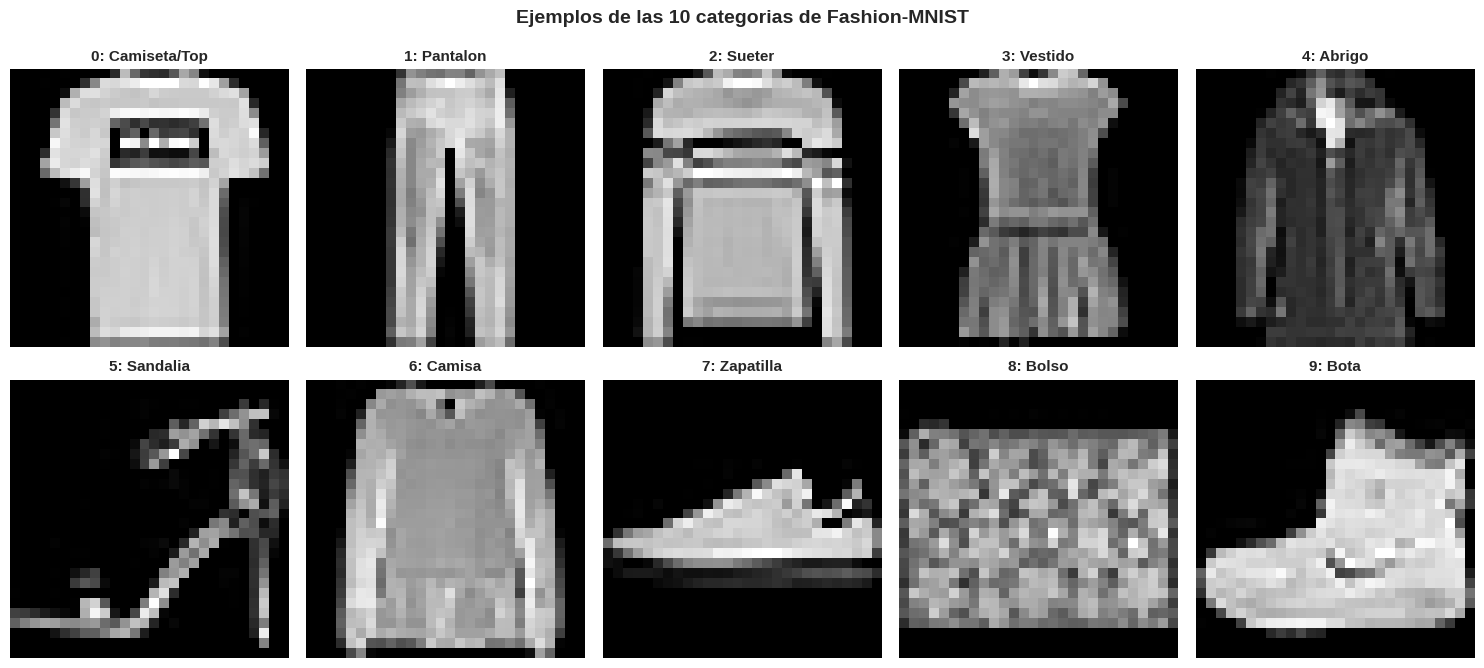

In [7]:
# ============================================================
# Visualizar ejemplos de cada categoria
# ============================================================
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

for i in range(10):
    ax = axes[i // 5, i % 5]
    # Encontrar el primer ejemplo de la clase i
    idx = np.where(y_train_full == i)[0][0]
    ax.imshow(x_train_full[idx], cmap='gray')
    ax.set_title(f'{i}: {nombres_clases[i]}', fontsize=11, fontweight='bold')
    ax.axis('off')

plt.suptitle('Ejemplos de las 10 categorias de Fashion-MNIST', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

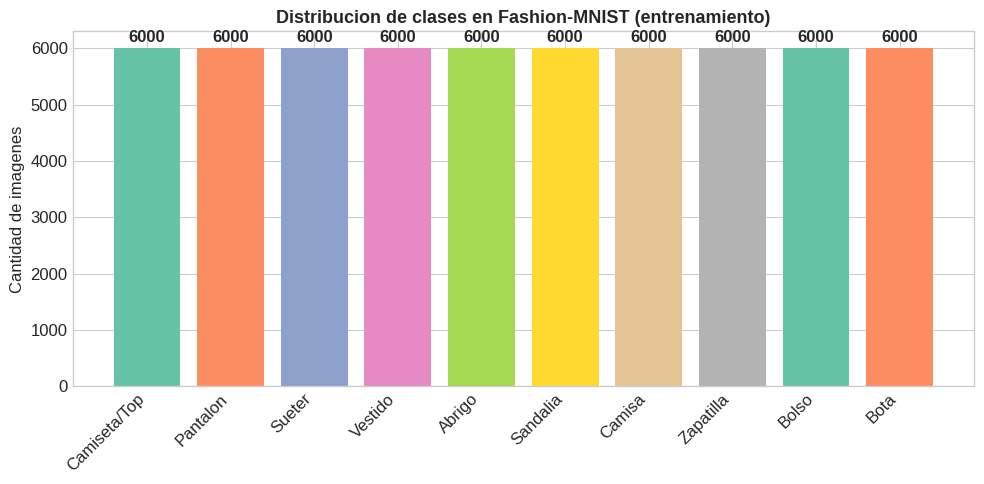

In [8]:
# ============================================================
# Distribucion de clases en el dataset
# ============================================================
fig, ax = plt.subplots(figsize=(10, 5))
valores, conteos = np.unique(y_train_full, return_counts=True)
barras = ax.bar([nombres_clases[v] for v in valores], conteos, color=sns.color_palette('Set2', 10))
ax.set_title('Distribucion de clases en Fashion-MNIST (entrenamiento)', fontsize=13, fontweight='bold')
ax.set_ylabel('Cantidad de imagenes')
plt.xticks(rotation=45, ha='right')

# Agregar valores sobre las barras
for barra, conteo in zip(barras, conteos):
    ax.text(barra.get_x() + barra.get_width()/2., barra.get_height() + 50,
            str(conteo), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# ============================================================
# Preprocesamiento de datos
# ============================================================

# 1. Normalizar pixeles al rango [0, 1]
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 2. Aplanar imagenes de 28x28 a vectores de 784
x_train_full_flat = x_train_full.reshape(-1, 784)
x_test_flat = x_test.reshape(-1, 784)

# 3. Dividir en entrenamiento y validacion (50000 train, 10000 val)
x_train = x_train_full_flat[:50000]
x_val = x_train_full_flat[50000:]
y_train = y_train_full[:50000]
y_val = y_train_full[50000:]

# 4. One-hot encoding de las etiquetas
y_train_cat = to_categorical(y_train, 10)
y_val_cat = to_categorical(y_val, 10)
y_test_cat = to_categorical(y_test, 10)

print(f"Entrenamiento: {x_train.shape}, etiquetas: {y_train_cat.shape}")
print(f"Validacion: {x_val.shape}, etiquetas: {y_val_cat.shape}")
print(f"Test: {x_test_flat.shape}, etiquetas: {y_test_cat.shape}")
print(f"\nRango de pixeles despues de normalizar: [{x_train.min():.1f}, {x_train.max():.1f}]")

Entrenamiento: (50000, 784), etiquetas: (50000, 10)
Validacion: (10000, 784), etiquetas: (10000, 10)
Test: (10000, 784), etiquetas: (10000, 10)

Rango de pixeles despues de normalizar: [0.0, 1.0]


---
## 4. Funcion auxiliar para graficar curvas de entrenamiento

Antes de comenzar los experimentos, definiremos una funcion reutilizable para graficar las curvas de perdida y precision durante el entrenamiento.

In [10]:
# ============================================================
# Funcion auxiliar para graficar curvas de entrenamiento
# ============================================================
def graficar_historia(historia, titulo='Curvas de Entrenamiento'):
    """
    Grafica las curvas de loss y accuracy del entrenamiento.

    Parametros:
    -----------
    historia : keras History object
        El objeto retornado por model.fit()
    titulo : str
        Titulo del grafico
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Curva de Loss
    ax1.plot(historia.history['loss'], label='Train Loss', linewidth=2)
    ax1.plot(historia.history['val_loss'], label='Val Loss', linewidth=2, linestyle='--')
    ax1.set_title('Perdida (Loss)', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Epoca')
    ax1.set_ylabel('Loss')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Curva de Accuracy
    ax2.plot(historia.history['accuracy'], label='Train Accuracy', linewidth=2)
    ax2.plot(historia.history['val_accuracy'], label='Val Accuracy', linewidth=2, linestyle='--')
    ax2.set_title('Precision (Accuracy)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Epoca')
    ax2.set_ylabel('Accuracy')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.suptitle(titulo, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print("Funcion graficar_historia() definida correctamente.")

Funcion graficar_historia() definida correctamente.


---
## 5. Experimentacion Guiada

A continuacion realizaremos 7 experimentos sistematicos para entender el impacto de cada tecnica de optimizacion y regularizacion.

---

### EXPERIMENTO 1: Provocar Overfitting Intencionalmente

**Objetivo:** Construir un modelo demasiado grande y entrenarlo con pocos datos para provocar overfitting claro. Esto nos servira como **linea base** para comparar las tecnicas de regularizacion.

**Estrategia:**
- Modelo grande: 3 capas ocultas de 512 neuronas cada una
- Solo 500 muestras de entrenamiento (muy pocas)
- 100 epocas (muchas)
- Sin ninguna tecnica de regularizacion

In [11]:
# ============================================================
# EXPERIMENTO 1: Provocar Overfitting
# ============================================================

# Tomar solo 500 muestras para entrenar (provocar overfitting)
x_train_small = x_train[:500]
y_train_small_cat = y_train_cat[:500]

print(f"Muestras de entrenamiento: {x_train_small.shape[0]}")
print(f"Muestras de validacion: {x_val.shape[0]}")
print(f"Ratio train/val: {x_train_small.shape[0]/x_val.shape[0]:.2f}")
print("\nEste ratio tan bajo casi garantiza overfitting con un modelo grande.")

Muestras de entrenamiento: 500
Muestras de validacion: 10000
Ratio train/val: 0.05

Este ratio tan bajo casi garantiza overfitting con un modelo grande.


In [12]:
# ============================================================
# Construir un modelo deliberadamente grande para overfitting
# ============================================================
tf.random.set_seed(SEED)

modelo_overfit = keras.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(512, activation='relu'),    # Capa oculta 1: 512 neuronas
    layers.Dense(512, activation='relu'),    # Capa oculta 2: 512 neuronas
    layers.Dense(512, activation='relu'),    # Capa oculta 3: 512 neuronas
    layers.Dense(10, activation='softmax')   # Capa de salida: 10 clases
])

modelo_overfit.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ver resumen del modelo
modelo_overfit.summary()
print(f"\nTotal de parametros: {modelo_overfit.count_params():,}")
print(f"Muestras de entrenamiento: {x_train_small.shape[0]}")
print(f"Ratio parametros/muestras: {modelo_overfit.count_params()/x_train_small.shape[0]:.0f}")
print("\nCon tantos parametros y tan pocos datos, el overfitting es inevitable.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 932,362 (3.56 MB)

 Trainable params: 932,362 (3.56 MB)

 Non-trainable params: 0 (0.00 B)


Total de parametros: 932,362
Muestras de entrenamiento: 500
Ratio parametros/muestras: 1865

Con tantos parametros y tan pocos datos, el overfitting es inevitable.


In [13]:
# ============================================================
# Entrenar el modelo overfit por 100 epocas
# ============================================================
print("Entrenando modelo sobreajustado (100 epocas, 500 muestras)...")
print("Observa como la brecha entre train y validacion crece con las epocas.\n")

historia_overfit = modelo_overfit.fit(
    x_train_small, y_train_small_cat,
    epochs=100,
    batch_size=32,
    validation_data=(x_val, y_val_cat),
    verbose=1
)

Entrenando modelo sobreajustado (100 epocas, 500 muestras)...
Observa como la brecha entre train y validacion crece con las epocas.

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.3387 - loss: 1.8085 - val_accuracy: 0.5612 - val_loss: 1.1299
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6948 - loss: 0.8616 - val_accuracy: 0.7314 - val_loss: 0.8382
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8063 - loss: 0.5911 - val_accuracy: 0.7181 - val_loss: 0.7869
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8226 - loss: 0.4831 - val_accuracy: 0.7178 - val_loss: 0.8605
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8524 - loss: 0.4488 - val_accuracy: 0.7175 - val_loss: 1.0233
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8544 - loss: 0.3884 - val_accuracy: 0.7321 - val_loss: 0.8759
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8730 - loss: 0.3423 - val_accura

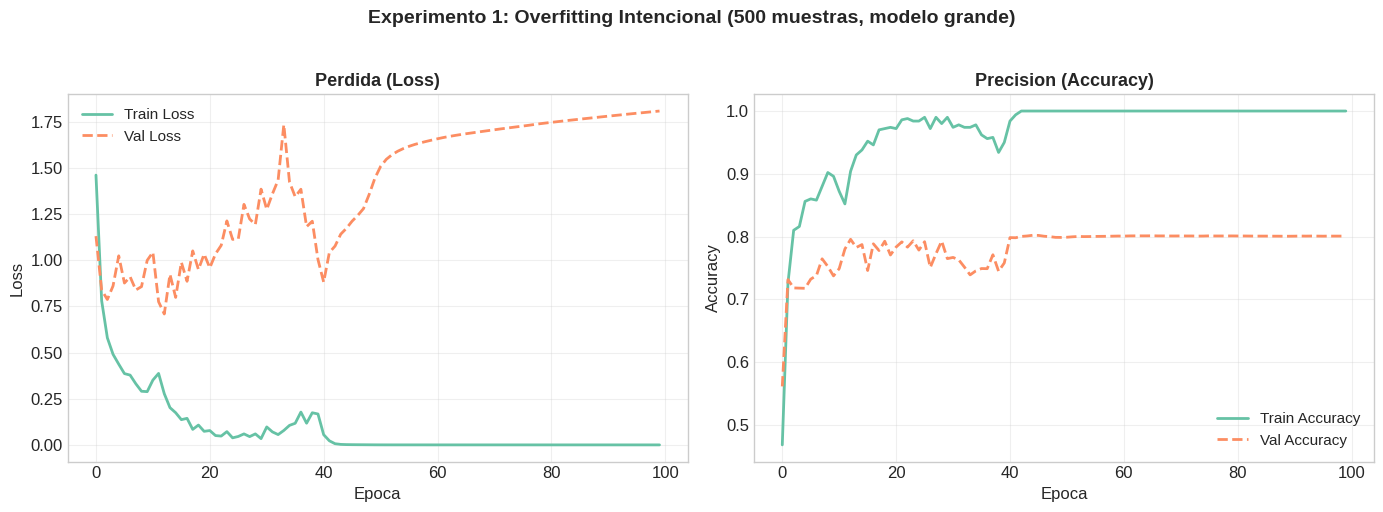


RESULTADOS DEL EXPERIMENTO 1
Train Loss final:  0.0000
Val Loss final:    1.8070
Train Accuracy:    1.0000
Val Accuracy:      0.8007

Brecha de accuracy: 0.1993

Una brecha grande indica overfitting severo.


In [14]:
# ============================================================
# Graficar las curvas de entrenamiento del modelo overfit
# ============================================================
graficar_historia(historia_overfit, 'Experimento 1: Overfitting Intencional (500 muestras, modelo grande)')

# Mostrar metricas finales
print("\n" + "="*50)
print("RESULTADOS DEL EXPERIMENTO 1")
print("="*50)
print(f"Train Loss final:  {historia_overfit.history['loss'][-1]:.4f}")
print(f"Val Loss final:    {historia_overfit.history['val_loss'][-1]:.4f}")
print(f"Train Accuracy:    {historia_overfit.history['accuracy'][-1]:.4f}")
print(f"Val Accuracy:      {historia_overfit.history['val_accuracy'][-1]:.4f}")
print(f"\nBrecha de accuracy: {historia_overfit.history['accuracy'][-1] - historia_overfit.history['val_accuracy'][-1]:.4f}")
print("\nUna brecha grande indica overfitting severo.")

### ✍️ Pregunta del Experimento 1

Observa las graficas anteriores y responde:

1. ¿En que epoca aproximadamente comienza el overfitting? ¿Como lo identificas en las graficas?
2. ¿Cual es la brecha entre el accuracy de entrenamiento y el de validacion al final del entrenamiento?
3. ¿Por que crees que el modelo memoriza los datos en lugar de aprender patrones generales?

### ✍️ Tu respuesta:

*Escribe aqui tu respuesta...*

---

### EXPERIMENTO 2: Comparacion de Optimizadores

**Objetivo:** Comparar el rendimiento de 5 optimizadores diferentes entrenando el mismo modelo con los mismos datos.

**Optimizadores a comparar:**
1. SGD con lr=0.01 (sin momentum)
2. SGD con lr=0.01 y momentum=0.9
3. RMSprop con lr=0.001
4. Adam con lr=0.001
5. Adagrad con lr=0.01

Usaremos el dataset **completo** y un modelo de tamaño moderado para que la comparacion sea justa.

In [15]:
# ============================================================
# Funcion para crear el modelo base (mismo para todos los optimizadores)
# ============================================================
def crear_modelo_base():
    """
    Crea un modelo con la misma arquitectura para
    comparar optimizadores de forma justa.
    """
    tf.random.set_seed(SEED)
    modelo = keras.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return modelo

print("Funcion crear_modelo_base() definida.")

Funcion crear_modelo_base() definida.


In [16]:
# ============================================================
# EXPERIMENTO 2: Entrenar con 5 optimizadores diferentes
# ============================================================

# Definir los optimizadores a comparar
optimizadores = {
    'SGD (lr=0.01)': keras.optimizers.SGD(learning_rate=0.01),
    'SGD + Momentum': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001),
    'Adam': keras.optimizers.Adam(learning_rate=0.001),
    'Adagrad': keras.optimizers.Adagrad(learning_rate=0.01)
}

# Diccionario para almacenar las historias de entrenamiento
historias_opt = {}

EPOCAS_OPT = 30  # Suficiente para ver las diferencias

for nombre, optimizador in optimizadores.items():
    print(f"\n{'='*50}")
    print(f"Entrenando con: {nombre}")
    print(f"{'='*50}")

    # Crear un modelo nuevo con la misma arquitectura
    modelo = crear_modelo_base()
    modelo.compile(
        optimizer=optimizador,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Entrenar
    historia = modelo.fit(
        x_train, y_train_cat,
        epochs=EPOCAS_OPT,
        batch_size=128,
        validation_data=(x_val, y_val_cat),
        verbose=0  # Silencioso para no saturar la salida
    )

    historias_opt[nombre] = historia

    # Mostrar resultado final
    val_acc = historia.history['val_accuracy'][-1]
    val_loss = historia.history['val_loss'][-1]
    print(f"  Val Accuracy: {val_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")

print("\nTodos los optimizadores entrenados exitosamente.")


Entrenando con: SGD (lr=0.01)
  Val Accuracy: 0.8684
  Val Loss: 0.3755

Entrenando con: SGD + Momentum
  Val Accuracy: 0.8899
  Val Loss: 0.3379

Entrenando con: RMSprop
  Val Accuracy: 0.8821
  Val Loss: 0.5722

Entrenando con: Adam
  Val Accuracy: 0.8728
  Val Loss: 0.4971

Entrenando con: Adagrad
  Val Accuracy: 0.8812
  Val Loss: 0.3313

Todos los optimizadores entrenados exitosamente.


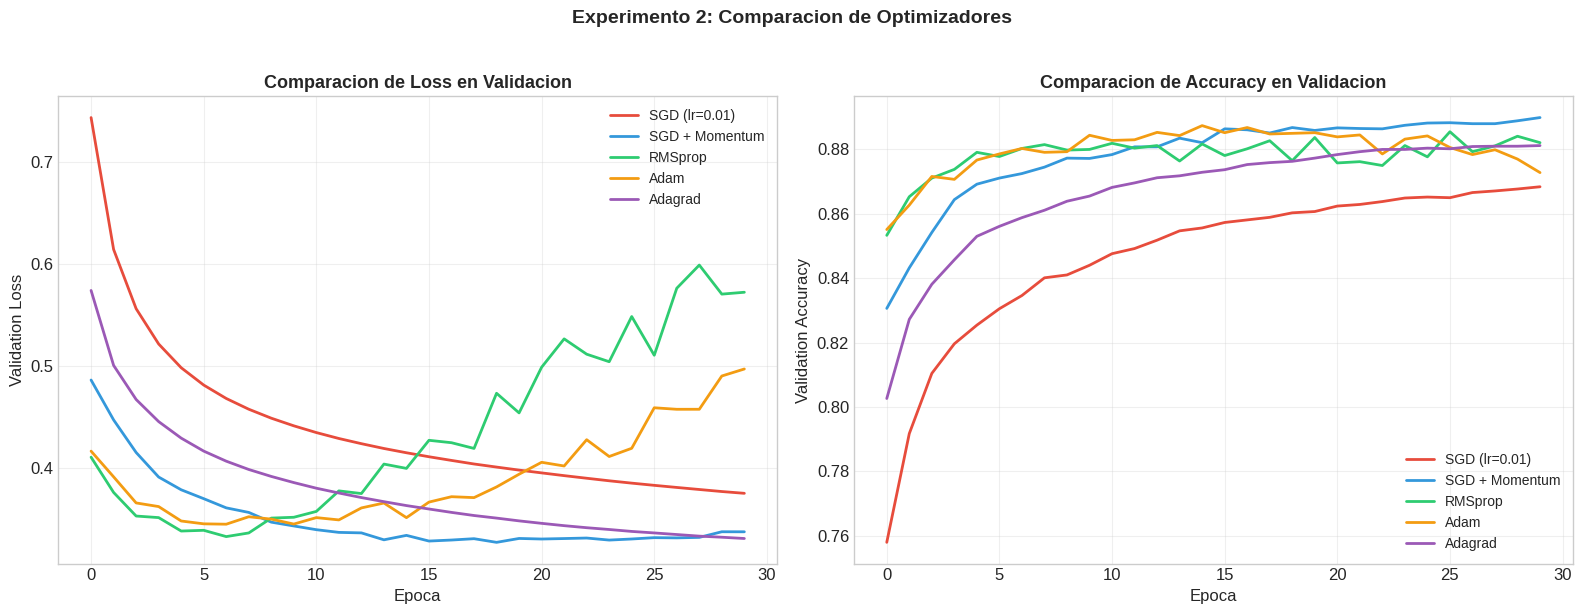

In [17]:
# ============================================================
# Graficar comparacion de optimizadores: Loss
# ============================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colores = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

for i, (nombre, historia) in enumerate(historias_opt.items()):
    ax1.plot(historia.history['val_loss'], label=nombre, linewidth=2, color=colores[i])
    ax2.plot(historia.history['val_accuracy'], label=nombre, linewidth=2, color=colores[i])

ax1.set_title('Comparacion de Loss en Validacion', fontsize=13, fontweight='bold')
ax1.set_xlabel('Epoca')
ax1.set_ylabel('Validation Loss')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.set_title('Comparacion de Accuracy en Validacion', fontsize=13, fontweight='bold')
ax2.set_xlabel('Epoca')
ax2.set_ylabel('Validation Accuracy')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.suptitle('Experimento 2: Comparacion de Optimizadores', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [18]:
# ============================================================
# Tabla comparativa de optimizadores
# ============================================================
print("\n" + "="*80)
print("TABLA COMPARATIVA DE OPTIMIZADORES")
print("="*80)
print(f"{'Optimizador':<20} {'Val Acc Final':>14} {'Val Loss Final':>15} {'Mejor Val Acc':>14} {'Epoca Mejor':>12}")
print("-"*80)

for nombre, historia in historias_opt.items():
    val_acc_final = historia.history['val_accuracy'][-1]
    val_loss_final = historia.history['val_loss'][-1]
    mejor_val_acc = max(historia.history['val_accuracy'])
    epoca_mejor = np.argmax(historia.history['val_accuracy']) + 1

    print(f"{nombre:<20} {val_acc_final:>14.4f} {val_loss_final:>15.4f} {mejor_val_acc:>14.4f} {epoca_mejor:>12}")

print("-"*80)


TABLA COMPARATIVA DE OPTIMIZADORES
Optimizador           Val Acc Final  Val Loss Final  Mejor Val Acc  Epoca Mejor
--------------------------------------------------------------------------------
SGD (lr=0.01)                0.8684          0.3755         0.8684           30
SGD + Momentum               0.8899          0.3379         0.8899           30
RMSprop                      0.8821          0.5722         0.8855           26
Adam                         0.8728          0.4971         0.8874           15
Adagrad                      0.8812          0.3313         0.8812           30
--------------------------------------------------------------------------------


### ✍️ Pregunta del Experimento 2

Analiza las graficas y la tabla comparativa:

1. ¿Cual optimizador convergio mas rapido (alcanzo buen accuracy en menos epocas)?
2. ¿Cual obtuvo el mejor resultado final en accuracy?
3. ¿Siempre coincide el que converge mas rapido con el que obtiene mejor resultado final? ¿Por que?
4. ¿Por que Adam es el optimizador mas popular en la practica?

### ✍️ Tu respuesta:

*Escribe aqui tu respuesta...*

---

### EXPERIMENTO 3: Regularizacion L1 y L2

**Objetivo:** Aplicar regularizacion L2 con diferentes intensidades al modelo sobreajustado del Experimento 1 y observar como reduce el overfitting.

Vamos a retomar la configuracion del Experimento 1 (modelo grande, solo 500 muestras) y probar regularizacion L2 con valores:
- Sin regularizacion (linea base)
- L2 = 0.001 (suave)
- L2 = 0.01 (moderada)
- L2 = 0.1 (fuerte)

In [19]:
# ============================================================
# EXPERIMENTO 3: Regularizacion L2 con diferentes valores
# ============================================================

valores_l2 = {
    'Sin regularizacion': None,
    'L2 = 0.001': 0.001,
    'L2 = 0.01': 0.01,
    'L2 = 0.1': 0.1
}

historias_l2 = {}

for nombre, valor_l2 in valores_l2.items():
    print(f"\nEntrenando: {nombre}...")

    tf.random.set_seed(SEED)

    # Crear modelo con o sin regularizacion L2
    if valor_l2 is not None:
        reg = regularizers.l2(valor_l2)
    else:
        reg = None

    modelo_l2 = keras.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(512, activation='relu', kernel_regularizer=reg),
        layers.Dense(512, activation='relu', kernel_regularizer=reg),
        layers.Dense(512, activation='relu', kernel_regularizer=reg),
        layers.Dense(10, activation='softmax')
    ])

    modelo_l2.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    historia = modelo_l2.fit(
        x_train_small, y_train_small_cat,
        epochs=100,
        batch_size=32,
        validation_data=(x_val, y_val_cat),
        verbose=0
    )

    historias_l2[nombre] = historia
    print(f"  Train Acc: {historia.history['accuracy'][-1]:.4f} | Val Acc: {historia.history['val_accuracy'][-1]:.4f}")

print("\nExperimento 3 completado.")


Entrenando: Sin regularizacion...
  Train Acc: 1.0000 | Val Acc: 0.8044

Entrenando: L2 = 0.001...
  Train Acc: 1.0000 | Val Acc: 0.7941

Entrenando: L2 = 0.01...
  Train Acc: 0.9860 | Val Acc: 0.7134

Entrenando: L2 = 0.1...
  Train Acc: 0.7500 | Val Acc: 0.6770

Experimento 3 completado.


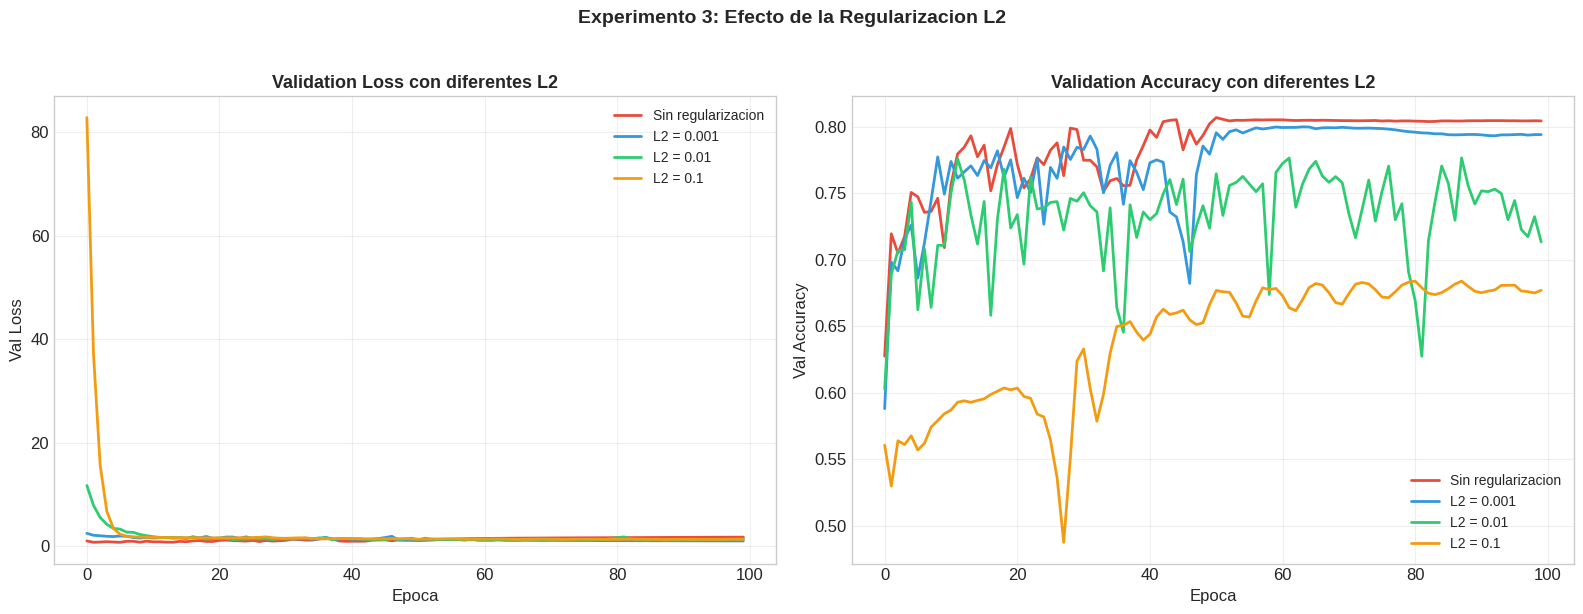


TABLA COMPARATIVA - REGULARIZACION L2
Configuracion           Train Acc    Val Acc     Brecha  Mejor Val Acc
----------------------------------------------------------------------
Sin regularizacion         1.0000     0.8044     0.1956         0.8069
L2 = 0.001                 1.0000     0.7941     0.2059         0.7999
L2 = 0.01                  0.9860     0.7134     0.2726         0.7766
L2 = 0.1                   0.7500     0.6770     0.0730         0.6839
----------------------------------------------------------------------


In [20]:
# ============================================================
# Graficar comparacion de regularizacion L2
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colores_l2 = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for i, (nombre, historia) in enumerate(historias_l2.items()):
    # Loss de validacion
    axes[0].plot(historia.history['val_loss'], label=nombre, linewidth=2, color=colores_l2[i])
    # Accuracy de validacion
    axes[1].plot(historia.history['val_accuracy'], label=nombre, linewidth=2, color=colores_l2[i])

axes[0].set_title('Validation Loss con diferentes L2', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Epoca')
axes[0].set_ylabel('Val Loss')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Validation Accuracy con diferentes L2', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Epoca')
axes[1].set_ylabel('Val Accuracy')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Experimento 3: Efecto de la Regularizacion L2', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tabla comparativa
print("\n" + "="*70)
print("TABLA COMPARATIVA - REGULARIZACION L2")
print("="*70)
print(f"{'Configuracion':<22} {'Train Acc':>10} {'Val Acc':>10} {'Brecha':>10} {'Mejor Val Acc':>14}")
print("-"*70)

for nombre, historia in historias_l2.items():
    train_acc = historia.history['accuracy'][-1]
    val_acc = historia.history['val_accuracy'][-1]
    brecha = train_acc - val_acc
    mejor = max(historia.history['val_accuracy'])
    print(f"{nombre:<22} {train_acc:>10.4f} {val_acc:>10.4f} {brecha:>10.4f} {mejor:>14.4f}")

print("-"*70)

### ✍️ Pregunta del Experimento 3

1. ¿Que efecto tuvo la regularizacion L2 sobre el overfitting? Compara la brecha train-val entre los diferentes valores.
2. ¿Que pasa si el valor de regularizacion es demasiado alto (L2=0.1)? ¿Mejora o empeora el modelo?
3. ¿Cual valor de L2 te parece el mejor compromiso? ¿Por que?

### ✍️ Tu respuesta:

*Escribe aqui tu respuesta...*

---

### EXPERIMENTO 4: Dropout

**Objetivo:** Aplicar Dropout con diferentes tasas al modelo sobreajustado y observar su efecto.

Vamos a comparar 4 configuraciones:
- Sin Dropout (base sobreajustada)
- Dropout de 0.2 (20% neuronas desactivadas)
- Dropout de 0.5 (50% neuronas desactivadas)
- Dropout de 0.8 (80% neuronas desactivadas - excesivo)

In [21]:
# ============================================================
# EXPERIMENTO 4: Dropout con diferentes tasas
# ============================================================

tasas_dropout = {
    'Sin Dropout': 0.0,
    'Dropout 0.2': 0.2,
    'Dropout 0.5': 0.5,
    'Dropout 0.8': 0.8
}

historias_dropout = {}

for nombre, tasa in tasas_dropout.items():
    print(f"\nEntrenando: {nombre}...")

    tf.random.set_seed(SEED)

    # Construir modelo con Dropout
    capas = [layers.Input(shape=(784,))]
    for _ in range(3):
        capas.append(layers.Dense(512, activation='relu'))
        if tasa > 0:
            capas.append(layers.Dropout(tasa))
    capas.append(layers.Dense(10, activation='softmax'))

    modelo_drop = keras.Sequential(capas)

    modelo_drop.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    historia = modelo_drop.fit(
        x_train_small, y_train_small_cat,
        epochs=100,
        batch_size=32,
        validation_data=(x_val, y_val_cat),
        verbose=0
    )

    historias_dropout[nombre] = historia
    print(f"  Train Acc: {historia.history['accuracy'][-1]:.4f} | Val Acc: {historia.history['val_accuracy'][-1]:.4f}")

print("\nExperimento 4 completado.")


Entrenando: Sin Dropout...
  Train Acc: 1.0000 | Val Acc: 0.8010

Entrenando: Dropout 0.2...
  Train Acc: 0.9940 | Val Acc: 0.7916

Entrenando: Dropout 0.5...
  Train Acc: 0.9520 | Val Acc: 0.7976

Entrenando: Dropout 0.8...
  Train Acc: 0.5500 | Val Acc: 0.6842

Experimento 4 completado.


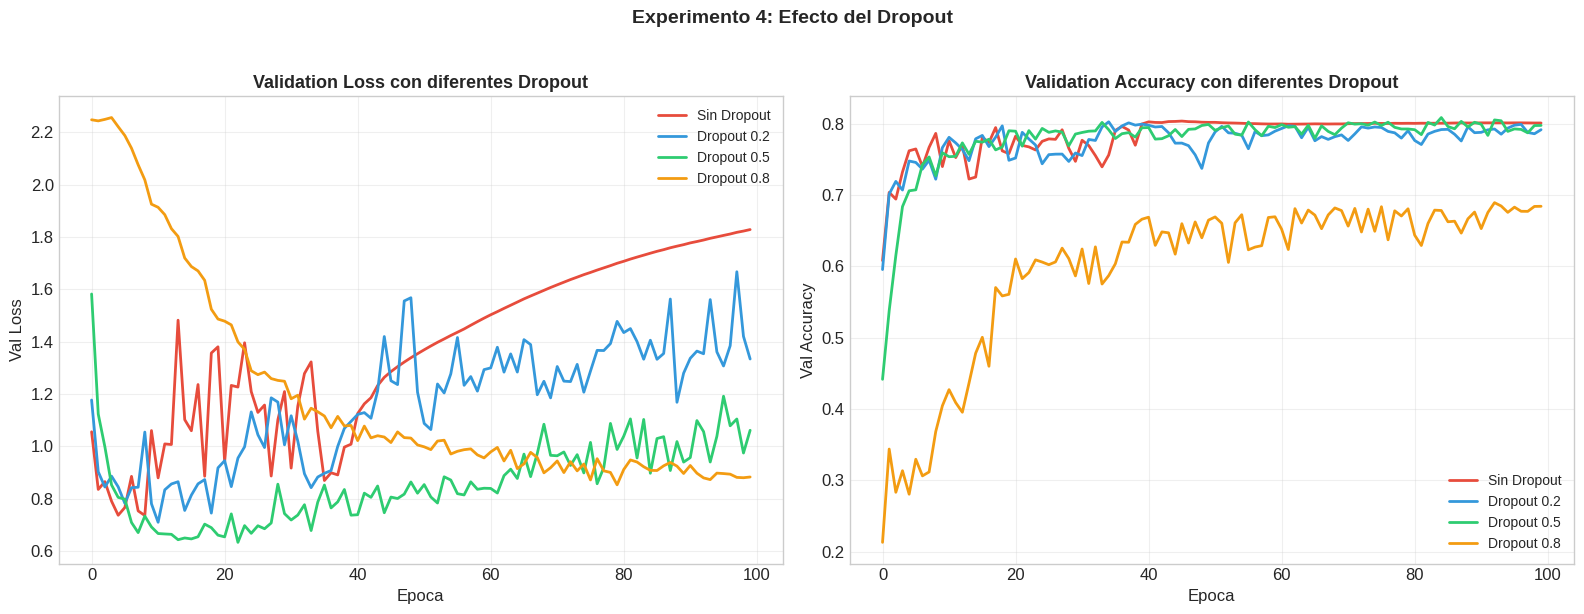


TABLA COMPARATIVA - DROPOUT
Configuracion       Train Acc    Val Acc     Brecha  Mejor Val Acc
----------------------------------------------------------------------
Sin Dropout            1.0000     0.8010     0.1990         0.8037
Dropout 0.2            0.9940     0.7916     0.2024         0.8027
Dropout 0.5            0.9520     0.7976     0.1544         0.8086
Dropout 0.8            0.5500     0.6842    -0.1342         0.6893
----------------------------------------------------------------------


In [22]:
# ============================================================
# Graficar comparacion de Dropout
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colores_drop = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for i, (nombre, historia) in enumerate(historias_dropout.items()):
    axes[0].plot(historia.history['val_loss'], label=nombre, linewidth=2, color=colores_drop[i])
    axes[1].plot(historia.history['val_accuracy'], label=nombre, linewidth=2, color=colores_drop[i])

axes[0].set_title('Validation Loss con diferentes Dropout', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Epoca')
axes[0].set_ylabel('Val Loss')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Validation Accuracy con diferentes Dropout', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Epoca')
axes[1].set_ylabel('Val Accuracy')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Experimento 4: Efecto del Dropout', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tabla comparativa
print("\n" + "="*70)
print("TABLA COMPARATIVA - DROPOUT")
print("="*70)
print(f"{'Configuracion':<18} {'Train Acc':>10} {'Val Acc':>10} {'Brecha':>10} {'Mejor Val Acc':>14}")
print("-"*70)

for nombre, historia in historias_dropout.items():
    train_acc = historia.history['accuracy'][-1]
    val_acc = historia.history['val_accuracy'][-1]
    brecha = train_acc - val_acc
    mejor = max(historia.history['val_accuracy'])
    print(f"{nombre:<18} {train_acc:>10.4f} {val_acc:>10.4f} {brecha:>10.4f} {mejor:>14.4f}")

print("-"*70)

### ✍️ Pregunta del Experimento 4

1. ¿Cual tasa de Dropout dio el mejor resultado en validacion?
2. ¿Que pasa con Dropout demasiado alto (0.8)? Describe el comportamiento que observas.
3. ¿Por que Dropout se desactiva automaticamente durante la prediccion (inferencia)? ¿Que pasaria si no se desactivara?

### ✍️ Tu respuesta:

*Escribe aqui tu respuesta...*

---

### EXPERIMENTO 5: Batch Normalization

**Objetivo:** Comparar un modelo con y sin Batch Normalization para observar su efecto en la velocidad de convergencia y el accuracy final.

Usaremos el dataset completo para este experimento.

In [23]:
# ============================================================
# EXPERIMENTO 5: Batch Normalization
# ============================================================

# --- Modelo SIN Batch Normalization ---
print("Entrenando modelo SIN Batch Normalization...")
tf.random.set_seed(SEED)

modelo_sin_bn = keras.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

modelo_sin_bn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

historia_sin_bn = modelo_sin_bn.fit(
    x_train, y_train_cat,
    epochs=30,
    batch_size=128,
    validation_data=(x_val, y_val_cat),
    verbose=0
)
print(f"  Val Accuracy final: {historia_sin_bn.history['val_accuracy'][-1]:.4f}")

# --- Modelo CON Batch Normalization ---
print("\nEntrenando modelo CON Batch Normalization...")
tf.random.set_seed(SEED)

modelo_con_bn = keras.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),       # BN despues de la capa densa
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),       # BN despues de la capa densa
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),       # BN despues de la capa densa
    layers.Dense(10, activation='softmax')
])

modelo_con_bn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

historia_con_bn = modelo_con_bn.fit(
    x_train, y_train_cat,
    epochs=30,
    batch_size=128,
    validation_data=(x_val, y_val_cat),
    verbose=0
)
print(f"  Val Accuracy final: {historia_con_bn.history['val_accuracy'][-1]:.4f}")

print("\nExperimento 5 completado.")

Entrenando modelo SIN Batch Normalization...
  Val Accuracy final: 0.8841

Entrenando modelo CON Batch Normalization...
  Val Accuracy final: 0.8645

Experimento 5 completado.


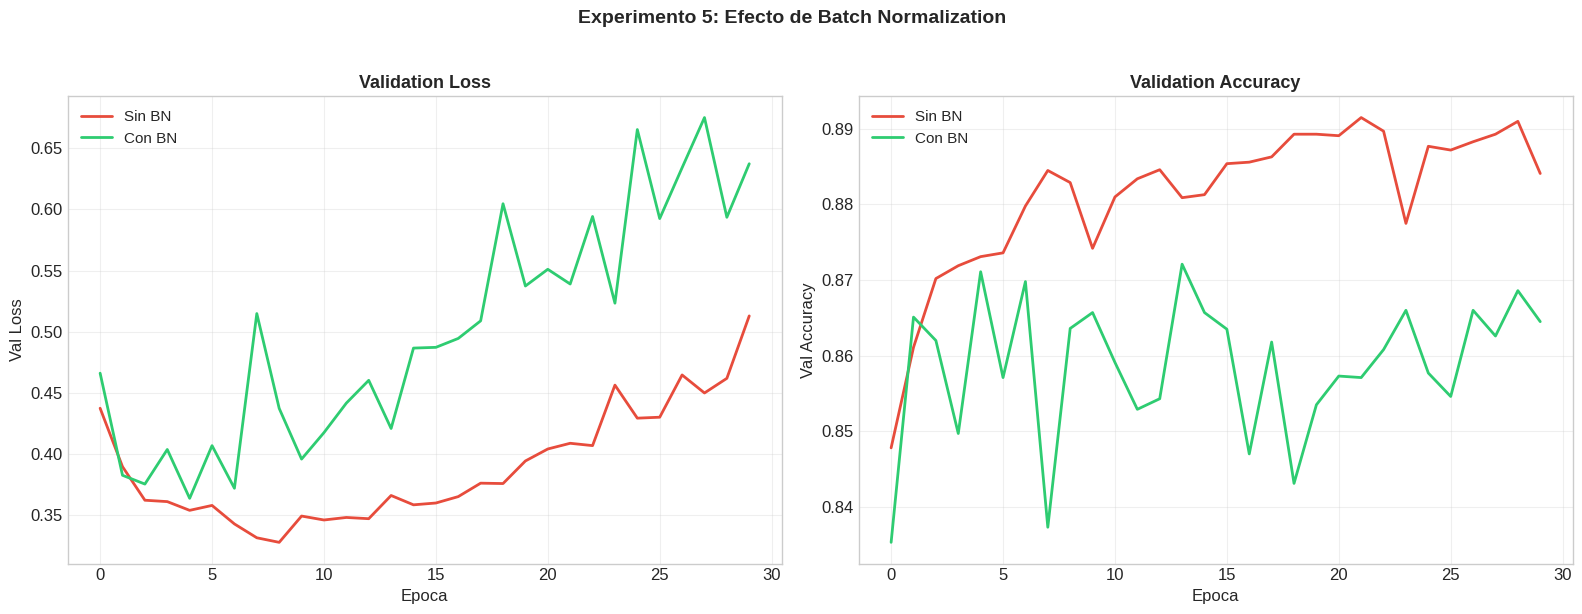


COMPARACION BATCH NORMALIZATION
Modelo               Val Acc Epoca 5 Val Acc Epoca 15  Val Acc Final
------------------------------------------------------------
Sin BN                        0.8731           0.8813         0.8841
Con BN                        0.8711           0.8657         0.8645
------------------------------------------------------------


In [24]:
# ============================================================
# Graficar comparacion Batch Normalization
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss
axes[0].plot(historia_sin_bn.history['val_loss'], label='Sin BN', linewidth=2, color='#e74c3c')
axes[0].plot(historia_con_bn.history['val_loss'], label='Con BN', linewidth=2, color='#2ecc71')
axes[0].set_title('Validation Loss', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Epoca')
axes[0].set_ylabel('Val Loss')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(historia_sin_bn.history['val_accuracy'], label='Sin BN', linewidth=2, color='#e74c3c')
axes[1].plot(historia_con_bn.history['val_accuracy'], label='Con BN', linewidth=2, color='#2ecc71')
axes[1].set_title('Validation Accuracy', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Epoca')
axes[1].set_ylabel('Val Accuracy')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Experimento 5: Efecto de Batch Normalization', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Comparacion numerica
print("\n" + "="*60)
print("COMPARACION BATCH NORMALIZATION")
print("="*60)
print(f"{'Modelo':<20} {'Val Acc Epoca 5':>15} {'Val Acc Epoca 15':>16} {'Val Acc Final':>14}")
print("-"*60)
print(f"{'Sin BN':<20} {historia_sin_bn.history['val_accuracy'][4]:>15.4f} {historia_sin_bn.history['val_accuracy'][14]:>16.4f} {historia_sin_bn.history['val_accuracy'][-1]:>14.4f}")
print(f"{'Con BN':<20} {historia_con_bn.history['val_accuracy'][4]:>15.4f} {historia_con_bn.history['val_accuracy'][14]:>16.4f} {historia_con_bn.history['val_accuracy'][-1]:>14.4f}")
print("-"*60)

### ✍️ Pregunta del Experimento 5

1. ¿Como afecto Batch Normalization a la velocidad de convergencia? Compara el accuracy en las primeras 5 epocas.
2. ¿Y al accuracy final despues de 30 epocas?
3. ¿En que situaciones crees que Batch Normalization seria mas beneficioso?

### ✍️ Tu respuesta:

*Escribe aqui tu respuesta...*

---

### EXPERIMENTO 6: Early Stopping

**Objetivo:** Comparar un modelo entrenado por 200 epocas sin restriccion contra uno con Early Stopping que se detiene automaticamente cuando deja de mejorar.

Usaremos el dataset completo y un modelo mediano.

In [25]:
# ============================================================
# EXPERIMENTO 6A: Entrenar SIN Early Stopping (200 epocas)
# ============================================================
print("Entrenando modelo SIN Early Stopping (200 epocas)...")
print("Esto puede tomar unos minutos.\n")

tf.random.set_seed(SEED)

modelo_sin_es = keras.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

modelo_sin_es.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

historia_sin_es = modelo_sin_es.fit(
    x_train, y_train_cat,
    epochs=200,
    batch_size=128,
    validation_data=(x_val, y_val_cat),
    verbose=0
)

# Evaluar en test
test_loss_sin_es, test_acc_sin_es = modelo_sin_es.evaluate(x_test_flat, y_test_cat, verbose=0)
print(f"Modelo SIN Early Stopping:")
print(f"  Epocas entrenadas: 200")
print(f"  Test Accuracy: {test_acc_sin_es:.4f}")

Entrenando modelo SIN Early Stopping (200 epocas)...
Esto puede tomar unos minutos.

Modelo SIN Early Stopping:
  Epocas entrenadas: 200
  Test Accuracy: 0.8873


In [26]:
# ============================================================
# EXPERIMENTO 6B: Entrenar CON Early Stopping
# ============================================================
print("Entrenando modelo CON Early Stopping (max 200 epocas, patience=10)...\n")

tf.random.set_seed(SEED)

modelo_con_es = keras.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

modelo_con_es.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Definir Early Stopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',           # Monitorear la perdida de validacion
    patience=10,                  # Esperar 10 epocas sin mejora antes de parar
    restore_best_weights=True,    # Restaurar los pesos de la mejor epoca
    verbose=1                     # Mostrar cuando se detiene
)

historia_con_es = modelo_con_es.fit(
    x_train, y_train_cat,
    epochs=200,
    batch_size=128,
    validation_data=(x_val, y_val_cat),
    callbacks=[early_stopping],
    verbose=0
)

# Evaluar en test
test_loss_con_es, test_acc_con_es = modelo_con_es.evaluate(x_test_flat, y_test_cat, verbose=0)
epocas_entrenadas = len(historia_con_es.history['loss'])
print(f"\nModelo CON Early Stopping:")
print(f"  Epocas entrenadas: {epocas_entrenadas}")
print(f"  Test Accuracy: {test_acc_con_es:.4f}")

Entrenando modelo CON Early Stopping (max 200 epocas, patience=10)...

Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.

Modelo CON Early Stopping:
  Epocas entrenadas: 16
  Test Accuracy: 0.8738


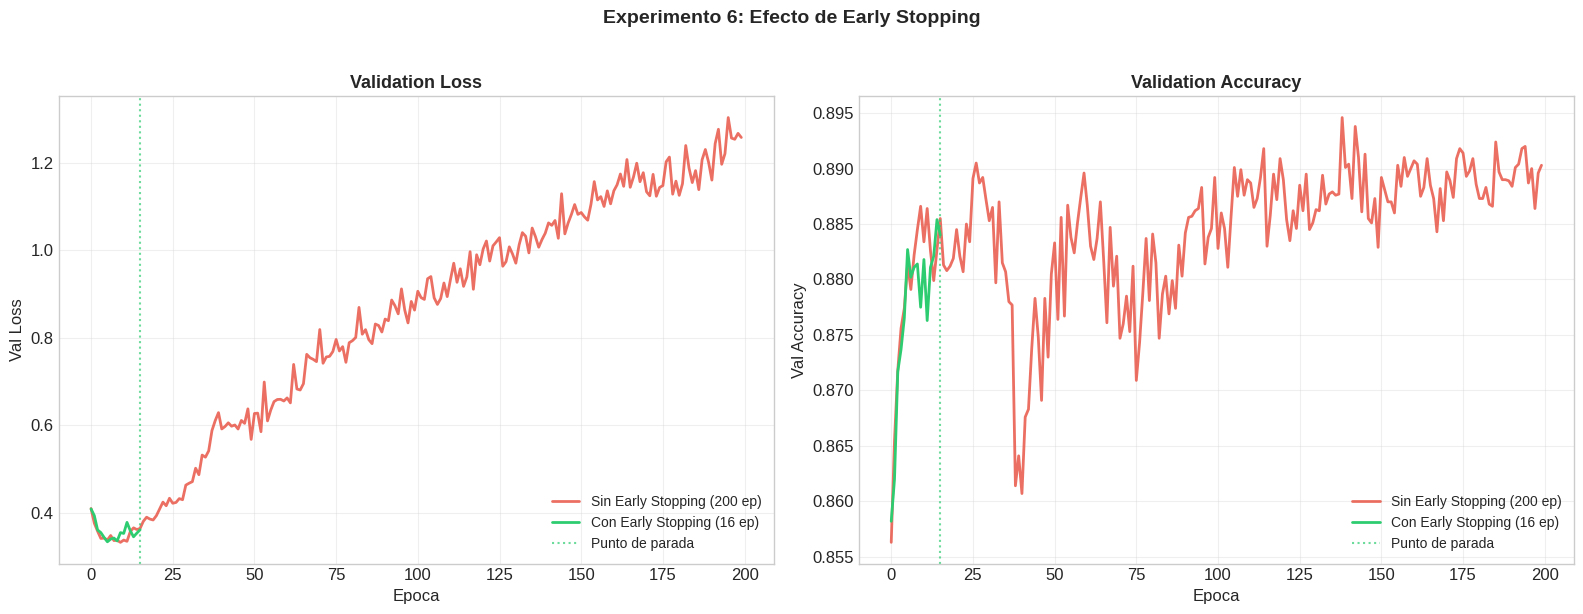


COMPARACION EARLY STOPPING
Modelo                           Epocas   Test Acc
------------------------------------------------------------
Sin Early Stopping                  200     0.8873
Con Early Stopping (p=10)            16     0.8738
------------------------------------------------------------

Epocas ahorradas: 184
Diferencia en Test Accuracy: -0.0135


In [27]:
# ============================================================
# Graficar comparacion Early Stopping
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss
axes[0].plot(historia_sin_es.history['val_loss'], label='Sin Early Stopping (200 ep)',
             linewidth=2, color='#e74c3c', alpha=0.8)
axes[0].plot(historia_con_es.history['val_loss'], label=f'Con Early Stopping ({epocas_entrenadas} ep)',
             linewidth=2, color='#2ecc71')
axes[0].axvline(x=epocas_entrenadas-1, color='#2ecc71', linestyle=':', alpha=0.7, label='Punto de parada')
axes[0].set_title('Validation Loss', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Epoca')
axes[0].set_ylabel('Val Loss')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(historia_sin_es.history['val_accuracy'], label='Sin Early Stopping (200 ep)',
             linewidth=2, color='#e74c3c', alpha=0.8)
axes[1].plot(historia_con_es.history['val_accuracy'], label=f'Con Early Stopping ({epocas_entrenadas} ep)',
             linewidth=2, color='#2ecc71')
axes[1].axvline(x=epocas_entrenadas-1, color='#2ecc71', linestyle=':', alpha=0.7, label='Punto de parada')
axes[1].set_title('Validation Accuracy', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Epoca')
axes[1].set_ylabel('Val Accuracy')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Experimento 6: Efecto de Early Stopping', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Comparacion final
print("\n" + "="*60)
print("COMPARACION EARLY STOPPING")
print("="*60)
print(f"{'Modelo':<30} {'Epocas':>8} {'Test Acc':>10}")
print("-"*60)
print(f"{'Sin Early Stopping':<30} {'200':>8} {test_acc_sin_es:>10.4f}")
print(f"{'Con Early Stopping (p=10)':<30} {epocas_entrenadas:>8} {test_acc_con_es:>10.4f}")
print("-"*60)
print(f"\nEpocas ahorradas: {200 - epocas_entrenadas}")
print(f"Diferencia en Test Accuracy: {test_acc_con_es - test_acc_sin_es:+.4f}")

### ✍️ Pregunta del Experimento 6

1. ¿En que epoca se detuvo el entrenamiento con Early Stopping?
2. ¿El modelo con Early Stopping obtuvo mejor accuracy en test que el que entreno las 200 epocas? ¿Por que?
3. ¿Que significa el parametro `patience=10`? ¿Que pasaria si usaras `patience=1`? ¿Y `patience=50`?

### ✍️ Tu respuesta:

*Escribe aqui tu respuesta...*

---

### EXPERIMENTO 7: Modelo Final - Combinando Todo

**Objetivo:** Construir un modelo que combine las mejores tecnicas aprendidas y compararlo con el modelo base sobreajustado del Experimento 1.

**Combinacion a usar:**
- Optimizador Adam
- Dropout (0.3)
- Batch Normalization
- Early Stopping (patience=15)
- Dataset completo
- Arquitectura moderada

In [28]:
# ============================================================
# EXPERIMENTO 7: Modelo final combinando todas las tecnicas
# ============================================================
print("Construyendo el modelo final con todas las tecnicas combinadas...\n")

tf.random.set_seed(SEED)

modelo_final = keras.Sequential([
    layers.Input(shape=(784,)),

    # Capa 1: Dense + BN + Dropout
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Capa 2: Dense + BN + Dropout
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Capa 3: Dense + BN + Dropout
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Capa de salida
    layers.Dense(10, activation='softmax')
])

modelo_final.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

modelo_final.summary()

Construyendo el modelo final con todas las tecnicas combinadas...



Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_65 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,554 (955.29 KB)

 Trainable params: 243,658 (951.79 KB)

 Non-trainable params: 896 (3.50 KB)

In [29]:
# ============================================================
# Definir callbacks para el modelo final
# ============================================================

# Early Stopping con patience generoso
early_stop_final = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: reducir learning rate cuando el modelo se estanca
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,           # Reducir el lr a la mitad
    patience=5,           # Esperar 5 epocas sin mejora
    min_lr=1e-6,          # Learning rate minimo
    verbose=1
)

print("Callbacks configurados:")
print("  - EarlyStopping: patience=15, restaura mejores pesos")
print("  - ReduceLROnPlateau: reduce lr x0.5 cada 5 epocas sin mejora")

Callbacks configurados:
  - EarlyStopping: patience=15, restaura mejores pesos
  - ReduceLROnPlateau: reduce lr x0.5 cada 5 epocas sin mejora


In [30]:
# ============================================================
# Entrenar el modelo final
# ============================================================
print("Entrenando modelo final (max 200 epocas con Early Stopping)...\n")

historia_final = modelo_final.fit(
    x_train, y_train_cat,
    epochs=200,
    batch_size=128,
    validation_data=(x_val, y_val_cat),
    callbacks=[early_stop_final, reduce_lr],
    verbose=1
)

epocas_final = len(historia_final.history['loss'])
print(f"\nEntrenamiento finalizado en {epocas_final} epocas.")

Entrenando modelo final (max 200 epocas con Early Stopping)...

Epoch 1/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6873 - loss: 0.9324 - val_accuracy: 0.8348 - val_loss: 0.4491 - learning_rate: 0.0010
Epoch 2/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8298 - loss: 0.4865 - val_accuracy: 0.8492 - val_loss: 0.4183 - learning_rate: 0.0010
Epoch 3/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8412 - loss: 0.4457 - val_accuracy: 0.8586 - val_loss: 0.3902 - learning_rate: 0.0010
Epoch 4/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8487 - loss: 0.4205 - val_accuracy: 0.8446 - val_loss: 0.4197 - learning_rate: 0.0010
Epoch 5/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8541 - loss: 0.4118 - val_accuracy: 0.8562 - val_loss: 0.3932 - learning_rate: 0.0010
Epoch 6/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8578 - loss: 0.4005 - val_accuracy: 0.8665 - val_loss: 0.3605 - learning_rate: 0.0010
Epoch 7/200
391/

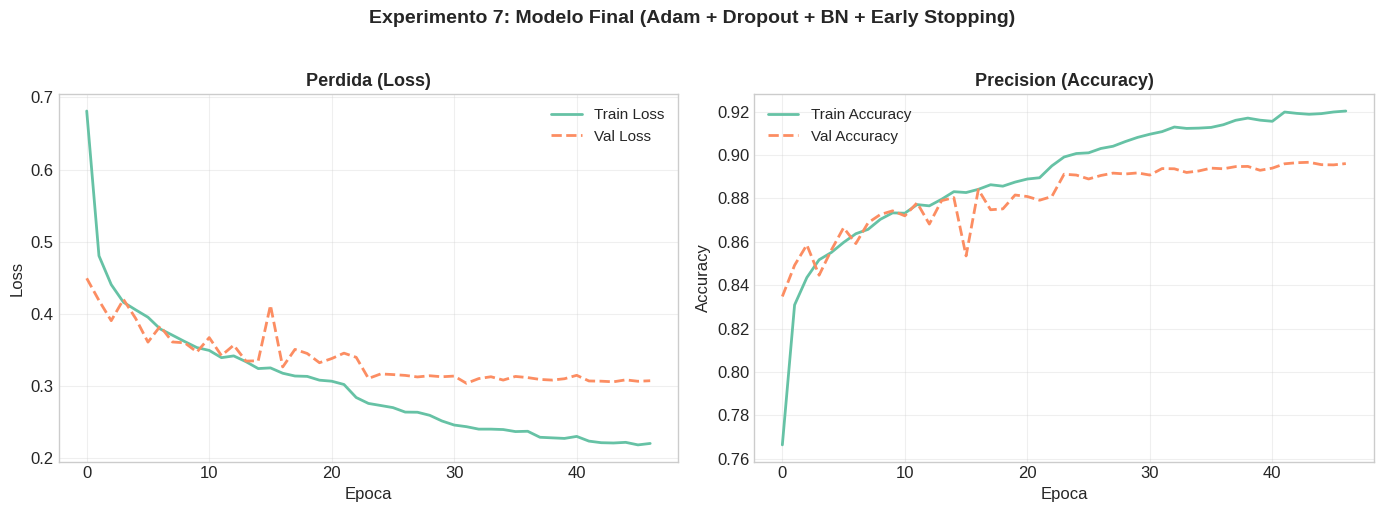

In [31]:
# ============================================================
# Graficar curvas del modelo final
# ============================================================
graficar_historia(historia_final, 'Experimento 7: Modelo Final (Adam + Dropout + BN + Early Stopping)')

In [32]:
# ============================================================
# Evaluar modelo final en test y comparar con modelo base
# ============================================================

# Evaluar modelo final en test
test_loss_final, test_acc_final = modelo_final.evaluate(x_test_flat, y_test_cat, verbose=0)

# Evaluar modelo base (overfit) en test
test_loss_base, test_acc_base = modelo_overfit.evaluate(x_test_flat, y_test_cat, verbose=0)

print("\n" + "="*70)
print("COMPARACION FINAL: Modelo Base vs Modelo Optimizado")
print("="*70)
print(f"{'Modelo':<35} {'Datos Train':>12} {'Test Acc':>10} {'Epocas':>8}")
print("-"*70)
print(f"{'Exp1: Base sobreajustado':<35} {'500':>12} {test_acc_base:>10.4f} {'100':>8}")
print(f"{'Exp7: Final optimizado':<35} {'50,000':>12} {test_acc_final:>10.4f} {epocas_final:>8}")
print("-"*70)

mejora = test_acc_final - test_acc_base
mejora_pct = (mejora / test_acc_base) * 100
print(f"\nMejora absoluta en Test Accuracy: {mejora:+.4f}")
print(f"Mejora porcentual: {mejora_pct:+.1f}%")
print(f"\nEl modelo final es significativamente mejor gracias a:")
print(f"  1. Mas datos de entrenamiento (50,000 vs 500)")
print(f"  2. Regularizacion con Dropout")
print(f"  3. Batch Normalization para convergencia estable")
print(f"  4. Early Stopping para evitar sobreajuste")
print(f"  5. Learning Rate Scheduling para ajuste fino")


COMPARACION FINAL: Modelo Base vs Modelo Optimizado
Modelo                               Datos Train   Test Acc   Epocas
----------------------------------------------------------------------
Exp1: Base sobreajustado                     500     0.7903      100
Exp7: Final optimizado                    50,000     0.8883       47
----------------------------------------------------------------------

Mejora absoluta en Test Accuracy: +0.0980
Mejora porcentual: +12.4%

El modelo final es significativamente mejor gracias a:
  1. Mas datos de entrenamiento (50,000 vs 500)
  2. Regularizacion con Dropout
  3. Batch Normalization para convergencia estable
  4. Early Stopping para evitar sobreajuste
  5. Learning Rate Scheduling para ajuste fino


### ✍️ Pregunta del Experimento 7

1. ¿Cuanto mejoro el modelo final respecto al modelo base del Experimento 1 (en terminos de accuracy en test)?
2. ¿Cuales de las tecnicas aplicadas consideras las mas impactantes? ¿Por que?
3. ¿Crees que se podria mejorar aun mas el modelo? ¿Como?

### ✍️ Tu respuesta:

*Escribe aqui tu respuesta...*

---
## 6. Sintesis y Reflexion Final

Has completado 7 experimentos donde aplicaste sistematicamente tecnicas de optimizacion y regularizacion. Ahora es momento de integrar todo lo aprendido.



```
# Esto tiene formato de código
```

### ✍️ Pregunta de Sintesis 1

Crea una tabla resumen con las tecnicas vistas en esta guia. La tabla debe incluir:
- Nombre de la tecnica
- Que problema resuelve
- Cuando usarla
- Hiperparametros clave

Tecnicas a incluir: SGD con Momentum, Adam, Regularizacion L2, Dropout, Batch Normalization, Early Stopping, ReduceLROnPlateau

### ✍️ Tu respuesta:

| Tecnica | Problema que resuelve | Cuando usarla | Hiperparametros clave |
|---------|----------------------|---------------|----------------------|
| ... | ... | ... | ... |

*Completa la tabla...*

### ✍️ Pregunta de Sintesis 2

Si recibes un modelo que tiene **overfitting severo** (train accuracy 99%, validation accuracy 60%), ¿cuales serian los primeros 3 pasos que tomarias para solucionarlo? Explica cada paso y por que lo priorizas en ese orden.

### ✍️ Tu respuesta:

*Escribe aqui tu respuesta...*

### ✍️ Pregunta de Sintesis 3

¿Crees que es posible **eliminar completamente** el overfitting? ¿Por que si o por que no? Justifica tu respuesta con lo aprendido en esta guia.

### ✍️ Tu respuesta:

*Escribe aqui tu respuesta...*

---
## 7. Reto Extra

### Desafio: Consigue el Mayor Accuracy Posible en Fashion-MNIST

**Objetivo:** Usando TODAS las tecnicas aprendidas en esta guia, construye el mejor modelo posible para Fashion-MNIST.

**Reglas:**
1. Solo puedes usar capas Dense (no convolucionales, esas seran en la Guia 05)
2. Debes probar al menos **3 combinaciones diferentes** de tecnicas
3. Documenta cada intento: arquitectura, hiperparametros, resultado
4. **Objetivo minimo: 90% accuracy en test**

**Sugerencias de cosas que puedes variar:**
- Numero de capas y neuronas por capa
- Tasa de Dropout
- Learning rate y optimizador
- Usar o no Batch Normalization
- Valores de regularizacion L2
- Patience del Early Stopping
- Batch size

In [34]:
# ============================================================
# RETO: Intento 1
# ============================================================
# Describe tu arquitectura y estrategia aqui:
# - Arquitectura: 784 -> 512 -> 256 -> 128 -> 10
#   * Capas ocultas Dense con activación ReLU
#   * Batch Normalization después de cada capa oculta
#   * Dropout para reducir overfitting
#   * Capa de salida Dense(10) con softmax
# - Optimizador: Adam con learning_rate = 0.001
# - Regularizacion:
#   * Dropout (0.3, 0.3, 0.2)
#   * EarlyStopping sobre val_loss (patience=15)
#   * ReduceLROnPlateau sobre val_loss (factor=0.5, patience=5)
# - Batch size: 64
# ============================================================

tf.random.set_seed(SEED)

# Tu modelo aqui
modelo_reto_1 = keras.Sequential([
    layers.Input(shape=(784,)),
    # Capas ocultas
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Capa de salida
    layers.Dense(10, activation='softmax')
])

modelo_reto_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar
historia_reto_1 = modelo_reto_1.fit(
    x_train, y_train_cat,
    epochs=200,
    batch_size=64,
    validation_data=(x_val, y_val_cat),
    callbacks=[
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ],
    verbose=0
)

# Evaluar
_, acc_reto_1 = modelo_reto_1.evaluate(x_test_flat, y_test_cat, verbose=0)
print(f"Intento 1 - Test Accuracy: {acc_reto_1:.4f}")
#

Intento 1 - Test Accuracy: 0.8915


In [36]:
# ============================================================
# RETO: Intento 2
# ============================================================
# - Arquitectura: 784 -> 512 -> 512 -> 256 -> 128 -> 10
#   * Dense + ReLU + BatchNorm + Dropout en capas ocultas
#   * Regularización L2 en todas las capas ocultas
# - Optimizador: Adam (learning_rate = 0.0005)
# - Regularizacion:
#   * L2 (1e-4) en kernel de capas ocultas
#   * Dropout (0.3, 0.3, 0.3, 0.25)
#   * EarlyStopping (patience=18)
#   * ReduceLROnPlateau (factor=0.5, patience=6)
# - Batch size: 64
# ============================================================

from tensorflow.keras import regularizers

tf.random.set_seed(SEED)

modelo_reto_2 = keras.Sequential([
    layers.Input(shape=(784,)),

    layers.Dense(512, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(512, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(10, activation='softmax')
])

modelo_reto_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

historia_reto_2 = modelo_reto_2.fit(
    x_train, y_train_cat,
    epochs=200,
    batch_size=64,
    validation_data=(x_val, y_val_cat),
    callbacks=[
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=18,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=6,
            min_lr=1e-6
        )
    ],
    verbose=0
)

_, acc_reto_2 = modelo_reto_2.evaluate(x_test_flat, y_test_cat, verbose=0)
print(f"Intento 2 - Test Accuracy: {acc_reto_2:.4f}")




Intento 2 - Test Accuracy: 0.8918


In [37]:
# ============================================================
# RETO: Intento 3
# ============================================================
# - Arquitectura: 784 -> 256 -> 256 -> 128 -> 10
#   * Dense + ReLU + Dropout (sin BatchNorm)
# - Optimizador: RMSprop (learning_rate = 0.0007)
# - Regularizacion:
#   * L2 suave (5e-5) en capas ocultas
#   * Dropout más alto (0.4, 0.4, 0.3)
#   * EarlyStopping (patience=15)
#   * ReduceLROnPlateau (factor=0.5, patience=5)
# - Batch size: 128
# ============================================================

tf.random.set_seed(SEED)

modelo_reto_3 = keras.Sequential([
    layers.Input(shape=(784,)),

    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(5e-5)),
    layers.Dropout(0.4),

    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(5e-5)),
    layers.Dropout(0.4),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(5e-5)),
    layers.Dropout(0.3),

    layers.Dense(10, activation='softmax')
])

modelo_reto_3.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0007),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

historia_reto_3 = modelo_reto_3.fit(
    x_train, y_train_cat,
    epochs=200,
    batch_size=128,
    validation_data=(x_val, y_val_cat),
    callbacks=[
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ],
    verbose=0
)

_, acc_reto_3 = modelo_reto_3.evaluate(x_test_flat, y_test_cat, verbose=0)
print(f"Intento 3 - Test Accuracy: {acc_reto_3:.4f}")

Intento 3 - Test Accuracy: 0.8879


In [38]:
# ============================================================
# RETO: Tabla resumen de resultados
# ============================================================

print("="*70)
print("TABLA DE RESULTADOS DEL RETO")
print("="*70)
print(f"{'Intento':<12} {'Arquitectura':<35} {'Test Accuracy':>14} {'Objetivo':>10}")
print("-"*70)
print(f"{'Intento 1':<12} {'512-256-128 + BN + Drop':<35} {acc_reto_1:>14.4f} {'>=0.90':>10}")
print(f"{'Intento 2':<12} {'512-512-256-128 + BN + L2':<35} {acc_reto_2:>14.4f} {'>=0.90':>10}")
print(f"{'Intento 3':<12} {'256-256-128 + Drop + L2':<35} {acc_reto_3:>14.4f} {'>=0.90':>10}")
print("-"*70)
print("\n¿Alcanzaste el 90%? Si no, ¿qué más podrías intentar?")
print("- Ajustar la tasa de dropout")
print("- Probar otros learning rates")
print("- Cambiar el batch size")
print("- Afinar la fuerza de L2 o quitarlo en alguna capa")

TABLA DE RESULTADOS DEL RETO
Intento      Arquitectura                         Test Accuracy   Objetivo
----------------------------------------------------------------------
Intento 1    512-256-128 + BN + Drop                     0.8915     >=0.90
Intento 2    512-512-256-128 + BN + L2                   0.8918     >=0.90
Intento 3    256-256-128 + Drop + L2                     0.8879     >=0.90
----------------------------------------------------------------------

¿Alcanzaste el 90%? Si no, ¿qué más podrías intentar?
- Ajustar la tasa de dropout
- Probar otros learning rates
- Cambiar el batch size
- Afinar la fuerza de L2 o quitarlo en alguna capa


---
## 8. Referencias

### Articulos fundamentales
- **Adam optimizer:** Kingma, D. P., & Ba, J. (2015). *Adam: A Method for Stochastic Optimization*. ICLR.
- **Dropout:** Srivastava, N., et al. (2014). *Dropout: A Simple Way to Prevent Neural Networks from Overfitting*. JMLR.
- **Batch Normalization:** Ioffe, S., & Szegedy, C. (2015). *Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift*. ICML.
- **Fashion-MNIST:** Xiao, H., Rasul, K., & Vollgraf, R. (2017). *Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms*.

### Documentacion oficial
- TensorFlow / Keras: [https://www.tensorflow.org/api_docs](https://www.tensorflow.org/api_docs)
- Keras Optimizers: [https://keras.io/api/optimizers/](https://keras.io/api/optimizers/)
- Keras Regularizers: [https://keras.io/api/layers/regularizers/](https://keras.io/api/layers/regularizers/)
- Keras Callbacks: [https://keras.io/api/callbacks/](https://keras.io/api/callbacks/)

### Recursos adicionales recomendados
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press. Capitulo 7: Regularization.
- Chollet, F. (2021). *Deep Learning with Python*, 2nd Edition. Manning Publications.

---

**Electiva II - Deep Learning | Tecnologico de Antioquia | 2026-1**

*Proxima guia: Guia 04 - Metricas de Evaluacion y Matrices de Confusion*